In [4]:
import models_nick
import numpy as np
import pandas as pd
import requests
from io import StringIO
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import geopandas as gpd

In [5]:
start_date = datetime.date.today() - datetime.timedelta(days=365*9)
end_date = datetime.date.today()
end_date.strftime("%Y%m%d")


'20240425'

In [6]:
#ophalen van KNMI data van het jaar 2023 van het station 344:Rotterdam en de vars:TG (Gemiddelde temp)
url = "https://www.daggegevens.knmi.nl/klimatologie/daggegevens"

params = {'start': '20150101', 'end': '20231231', 'stns':'344', 'vars':'TG:RH:NG:PG', 'fmt':'json'}

weather_rotterdam_json = requests.get(url, params=params)

if weather_rotterdam_json.status_code == 200:
    result = weather_rotterdam_json.text
else:
    print("Error:", weather_rotterdam_json.status_code)


In [7]:
df = pd.read_json(StringIO(result))
df.drop("station_code", axis=1, inplace=True)
df['TG'] = df['TG']/10
df['PG'] = df['PG']/10
df.columns = ["date", "temp", "precip", "cloud", "pressure"]
df.loc[df["precip"] == -1, "precip"] = 0
df2023 = df.loc[df['date']>'20230101']
df2022 = df.loc[(df['date']<'20230101') & (df['date']>'20220101')]
print(df.head())

                       date  temp  precip  cloud  pressure
0 2015-01-01 00:00:00+00:00   3.7       1    6.0    1029.9
1 2015-01-02 00:00:00+00:00   7.4      17    5.0    1026.3
2 2015-01-03 00:00:00+00:00   4.5      32    8.0    1023.4
3 2015-01-04 00:00:00+00:00   3.3       4    2.0    1033.5
4 2015-01-05 00:00:00+00:00   3.2       0    8.0    1030.6


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


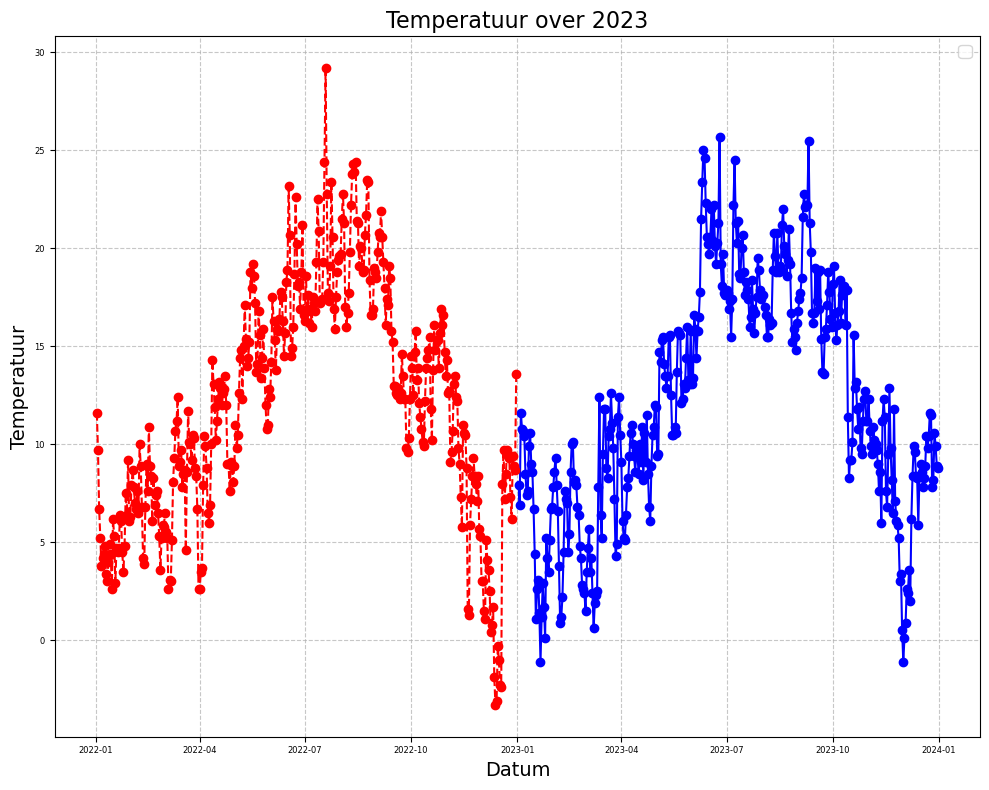

In [8]:
plt.figure(figsize=(10, 8))  # Figuurgrootte instellen
plt.plot(df2023['date'], df2023['temp'], marker='o', linestyle='-', color='b')
plt.plot(df2022['date'], df2022['temp'], marker='o', linestyle='--', color='r')
plt.title('Temperatuur over 2023', fontsize=16)  # Titel instellen
plt.xlabel('Datum', fontsize=14)  # X-as label instellen
plt.ylabel('Temperatuur', fontsize=14)  # Y-as label instellen
plt.xticks(fontsize=6)  # X-as tick labels grootte instellen
plt.yticks(fontsize=6)  # Y-as tick labels grootte instellen
plt.grid(True, linestyle='--', alpha=0.7)  # Raster toevoegen
plt.legend(fontsize=12)  # Legenda toevoegen
plt.tight_layout()  # Lay-out optimaliseren

# Grafiek weergeven
plt.show()

# Exploratory data analysis + data cleaning

In [9]:
print(df.describe())

              temp       precip        cloud     pressure
count  3287.000000  3287.000000  3284.000000  3287.000000
mean     11.464557    24.683906     5.905907  1015.669851
std       5.928479    47.891446     2.183616    10.082601
min      -5.900000     0.000000     0.000000   973.100000
25%       7.000000     0.000000     5.000000  1009.900000
50%      11.200000     1.000000     7.000000  1016.500000
75%      16.300000    27.000000     8.000000  1022.250000
max      29.400000   429.000000     8.000000  1046.700000


# feature engineering

Add some features to aid the model and give it more information

ideas are:
<ul>
<li>1,2 and 3 day lag</li>
<li>add sine wave with period of 1 year</l1>
</ul>

In [10]:
df_clean = df.reset_index()
df_clean.drop("date", axis=1, inplace=True)
df_clean = models_nick.create_lag(df_clean, lag_cols=["temp", "precip", "cloud", "pressure"], lag_num=[1,2,3])
df_clean.drop(["precip", "cloud", "pressure"], axis=1, inplace=True)
df_clean

,index,temp,temp_lag1,temp_lag2,temp_lag3,precip_lag1,precip_lag2,precip_lag3,cloud_lag1,cloud_lag2,cloud_lag3,pressure_lag1,pressure_lag2,pressure_lag3
3,3,3.3,4.5,7.4,3.7,32.0,17.0,1.0,8.0,5.0,6.0,1023.4,1026.3,1029.9
4,4,3.2,3.3,4.5,7.4,4.0,32.0,17.0,2.0,8.0,5.0,1033.5,1023.4,1026.3
5,5,3.0,3.2,3.3,4.5,0.0,4.0,32.0,8.0,2.0,8.0,1030.6,1033.5,1023.4
6,6,4.4,3.0,3.2,3.3,12.0,0.0,4.0,8.0,8.0,2.0,1022.0,1030.6,1033.5
7,7,6.9,4.4,3.0,3.2,15.0,12.0,0.0,5.0,8.0,8.0,1025.2,1022.0,1030.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3282,3282,8.2,7.8,11.5,11.6,9.0,142.0,116.0,7.0,8.0,8.0,1014.6,1006.0,1003.8
3283,3283,10.6,8.2,7.8,11.5,41.0,9.0,142.0,8.0,7.0,8.0,1011.6,1014.6,1006.0
3284,3284,9.9,10.6,8.2,7.8,11.0,41.0,9.0,8.0,8.0,7.0,1007.7,1011.6,1014.6
3285,3285,8.9,9.9,10.6,8.2,18.0,11.0,41.0,7.0,8.0,8.0,1006.3,1007.7,1011.6


In [11]:
# Sinus eruit gehaald WIP
# sinwave = models_nick.make_sin(len_sin=len(df_clean), period=365, offset=2, amplitude=10, mean=np.mean(df_clean["temp"]))
# df_clean["sin"] = sinwave
# plt.figure(figsize=(10,10))
# plt.plot(df_clean["index"], df_clean["temp"])
# plt.plot(df_clean["index"], df_clean["sin"])
# plt.xlim(0,500)

# create models

Most naive model: take the mean and predict the mean for every day

In [12]:
df_mean = pd.DataFrame(df_clean["index"].copy())
df_mean["temp"] = df_clean["temp"].mean()

yhat = df_mean.pop("temp")
ytrue = df_clean["temp"]
MAE = mean_absolute_error(ytrue, yhat)

print(f"The mean absolute error is: {MAE}")

The mean absolute error is: 4.988776276220586


In [13]:
df_reg = df_clean.copy()
df_reg.drop("index", axis=1, inplace=True)
df_reg = df_reg.dropna()

X = df_reg.copy()
y = X.pop("temp")
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=(1/9), shuffle=False)

reg = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, loss="absolute_error")
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
MAE = (mean_absolute_error(y_test, yhat))
print(f"the Mean absolute error is: {MAE}")

the Mean absolute error is: 1.3623243184864946


In [14]:
yhat = []
for row_idx in range(len(X_test)):
    pred = reg.predict(X_test.iloc[row_idx:row_idx+1,])
    yhat.append(pred)

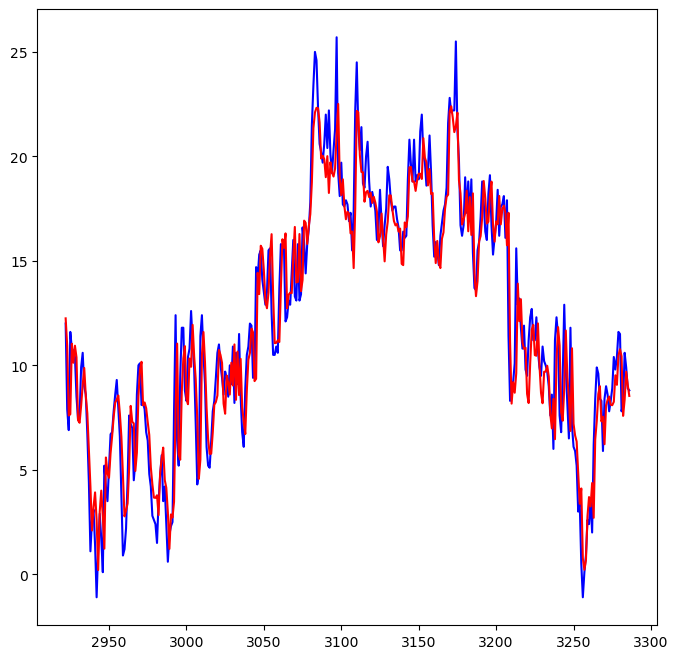

In [15]:
plt.figure(figsize=(8,8))
plt.plot(X_test.index,y_test, color = "b")
plt.plot(X_test.index,yhat, color = "r")

<Axes: >

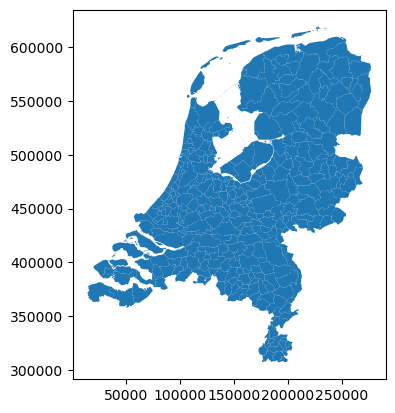

In [16]:
geo_statons = pd.read_csv("Stations_Coordinates_WP.txt", sep="\t")
# Haal de kaart met gemeentegrenzen op van PDOK
gemeentegrenzen = gpd.read_file("kaart.json")
gemeentegrenzen.plot()

In [17]:

import geopandas
# from geodatasets import get_path

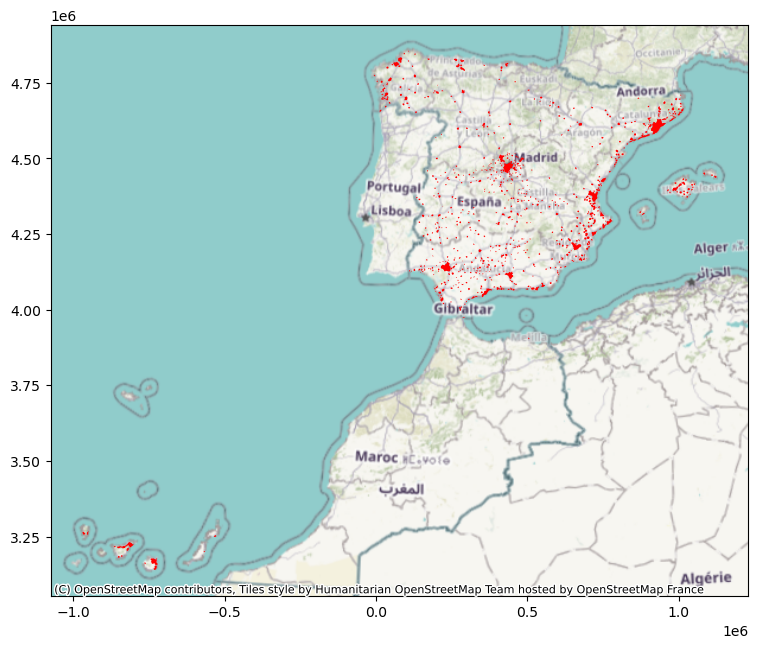

In [18]:
import contextily as cx
data_url = "https://ndownloader.figshare.com/files/20232174"
db = geopandas.read_file(data_url)
ax = db.plot(color="red", figsize=(9, 9))
cx.add_basemap(ax, crs=db.crs)

